# V2 Cascade Detection Demo - Face Detection with V2 Cascade

**V2 Cascade Improvements**:
- Uses V2 Cascade classifier (91.46% accuracy, 3 stages)
- 32k Haar features
- Multi-scale detection with image pyramid
- Non-maximum suppression
- Early rejection for faster processing

**Expected Performance** (single 200x180 image):
- Single-scale: ~1-2 min (faster due to early rejection)
- Multi-scale: ~4-6 min

**AI Usage**: Notebook structure assisted by Claude Code

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io, color
import pickle
import sys
from pathlib import Path
import time

sys.path.insert(0, str(Path.cwd().parent / 'src'))

from classifiers.cascade import CascadeClassifier
from detector.sliding_window import (
    sliding_window,
    multi_scale_detection,
    non_maximum_suppression,
    Detection
)

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("[OK] Imports complete")

✓ Numba successfully imported - JIT optimization available
[OK] Imports complete


## 1. Load V2 Cascade Classifier

Uses 3-stage cascade with 32k features (91.46% test accuracy)

In [2]:
# Load V2 Cascade
model_path = Path('../data/models/cascade_v2_3stage.pkl')
print(f'Loading V2 Cascade from {model_path}...')

cascade = CascadeClassifier.load(model_path)
print(f'Loaded: {cascade}')
print(f'  Stages: {len(cascade.stages)}')
for i, stage in enumerate(cascade.stages, 1):
    print(f"Stage {i}: {stage}")
    print(f'  Stage {i}: {len(stage.classifier.weak_classifiers)} features')

Loading V2 Cascade from ..\data\models\cascade_v2_3stage.pkl...
Loaded: CascadeClassifier(n_stages=3)
  Stages: 3
Stage 1: CascadeStage(stage=1, n_weak=20, thresh=0.329)
  Stage 1: 20 features
Stage 2: CascadeStage(stage=2, n_weak=50, thresh=0.454)
  Stage 2: 50 features
Stage 3: CascadeStage(stage=3, n_weak=130, thresh=0.497)
  Stage 3: 130 features


## 2. Load V2 Features

Must use same 32k features as training

In [3]:
# Load features (32k from V2)
features_path = Path('../data/models/v2_features_50k.pkl')
print(f'Loading features from {features_path}...')

with open(features_path, 'rb') as f:
    features = pickle.load(f)

print(f'Loaded {len(features)} features')

Loading features from ..\data\models\v2_features_50k.pkl...
Loaded 32384 features


## 3. Load Test Image

Loading test image: ..\Faces94\male\9326871\9326871.1.jpg
Image shape: (200, 180)


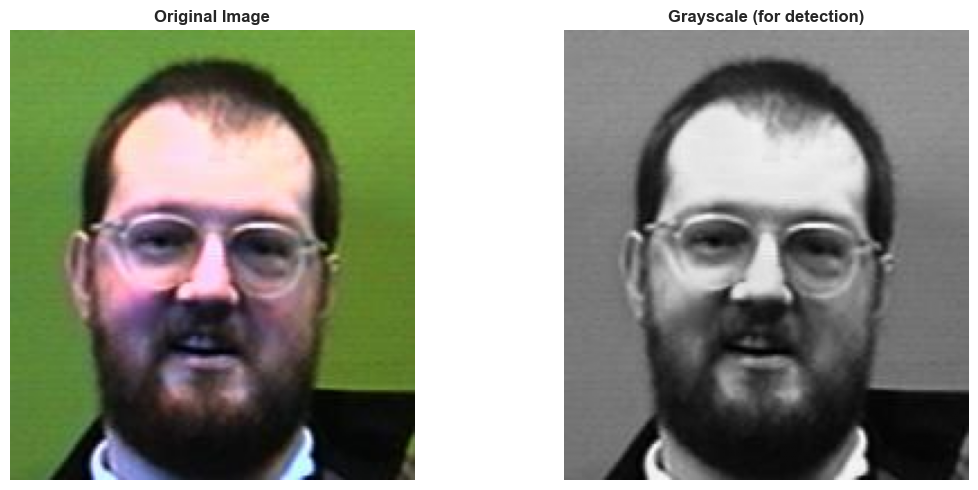

In [4]:
# Load sample image
test_image_path = Path('../Faces94/male/suatt/suatt.1.jpg')

if not test_image_path.exists():
    # Fallback to first available
    test_image_path = list(Path('../Faces94/male').glob('*/*.1.jpg'))[0]

print(f'Loading test image: {test_image_path}')
image = io.imread(test_image_path)

# Convert to grayscale
if len(image.shape) == 3:
    image_gray = color.rgb2gray(image)
    image_gray = (image_gray * 255).astype(np.uint8)
else:
    image_gray = image

print(f'Image shape: {image_gray.shape}')

# Display
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(image if len(image.shape) == 3 else image_gray, cmap='gray')
axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(image_gray, cmap='gray')
axes[1].set_title('Grayscale (for detection)', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 4. Single-Scale Detection

Expected time: ~1-2 minutes (faster due to cascade early rejection)

In [ ]:
# Parameters
window_size = 16
step_size = 2
threshold = 0.5  # Cascade outputs binary predictions

print(f'Running single-scale detection...')
print(f'  Window: {window_size}x{window_size}')
print(f'  Step: {step_size}')
print(f'  Threshold: {threshold}\n')

start_time = time.time()

detections_single = sliding_window(
    cascade,
    image_gray,
    features,
    window_size=window_size,
    step_size=step_size,
    threshold=threshold
)

elapsed = time.time() - start_time
print(f'\nTime: {elapsed:.1f} seconds ({elapsed/60:.2f} minutes)')
print(f'Found {len(detections_single)} detections')

# Debug: Show confidence range if detections found
if len(detections_single) > 0:
    confidences = [d.confidence for d in detections_single]
    print(f'Confidence range: [{min(confidences):.3f}, {max(confidences):.3f}]')
else:
    print('WARNING: No detections found! Try lowering threshold.')

Running single-scale detection...
  Window: 16x16
  Step: 2
  Threshold: 0.5

Scanning image 180x200 with 16x16 window, step=2
⚠ Using standard sliding window implementation (fallback)
  Numba available: True
  Cascade classifier detected


## 5. Visualize Single-Scale Results

In [ ]:
def visualize_detections(image, detections, title='Detections'):
    """Draw bounding boxes on image"""
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(image, cmap='gray')

    for det in detections:
        rect = patches.Rectangle(
            (det.x, det.y), det.width, det.height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

        # Add confidence if available
        if det.confidence < 1.0:
            ax.text(
                det.x, det.y - 2,
                f'{det.confidence:.2f}',
                color='red', fontsize=8,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
            )

    ax.set_title(f'{title} ({len(detections)} detections)', fontsize=13, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    return fig

# Visualize
fig = visualize_detections(image_gray, detections_single, 'V2 Cascade Single-Scale')
plt.savefig('../results/figures/v2_cascade_detection_single.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Multi-Scale Detection

Expected time: ~4-6 minutes (cascade should be faster than AdaBoost)

In [ ]:
# Multi-scale parameters
scale_factor = 1.2
threshold_ms = 0.5

print(f'Running multi-scale detection...')
print(f'  Scale factor: {scale_factor}')
print(f'  Threshold: {threshold_ms}\n')

start_time = time.time()

detections_ms = multi_scale_detection(
    cascade,
    image_gray,
    features,
    window_size=window_size,
    step_size=step_size,
    scale_factor=scale_factor,
    threshold=threshold_ms
)

elapsed = time.time() - start_time
print(f'\nTime: {elapsed:.1f} seconds ({elapsed/60:.2f} minutes)')
print(f'Total detections before NMS: {len(detections_ms)}')

## 7. Apply Non-Maximum Suppression

In [ ]:
# Apply NMS
overlap_threshold = 0.3

print(f'Applying NMS with IoU threshold: {overlap_threshold}')
detections_nms = non_maximum_suppression(detections_ms, overlap_threshold)

print(f'Detections after NMS: {len(detections_nms)}')

## 8. Compare Before/After NMS

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('V2 Cascade Multi-Scale Detection', fontsize=14, fontweight='bold')

# Before NMS
axes[0].imshow(image_gray, cmap='gray')
for det in detections_ms:
    rect = patches.Rectangle(
        (det.x, det.y), det.width, det.height,
        linewidth=1, edgecolor='orange', facecolor='none', alpha=0.5
    )
    axes[0].add_patch(rect)
axes[0].set_title(f'Before NMS\n{len(detections_ms)} detections', fontsize=11)
axes[0].axis('off')

# After NMS
axes[1].imshow(image_gray, cmap='gray')
for det in detections_nms:
    rect = patches.Rectangle(
        (det.x, det.y), det.width, det.height,
        linewidth=2, edgecolor='lime', facecolor='none'
    )
    axes[1].add_patch(rect)
axes[1].set_title(f'After NMS\n{len(detections_nms)} detections', fontsize=11)
axes[1].axis('off')

plt.tight_layout()
plt.savefig('../results/figures/v2_cascade_detection_multiscale_nms.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Test on Multiple Images

Expected time: ~8-12 min for 15 images (cascade should be faster than AdaBoost)

In [ ]:
# Load multiple test images from all categories
faces94_path = Path('../Faces94')

# Collect images from all categories (5 from each)
all_images = []
categories = ['female', 'male', 'malestaff']

for category in categories:
    cat_path = faces94_path / category
    if cat_path.exists():
        # Get all subdirectories (person folders)
        person_dirs = [d for d in cat_path.iterdir() if d.is_dir()]
        
        # Collect all images from this category
        cat_images = []
        for person_dir in person_dirs:
            images = list(person_dir.glob('*.jpg'))
            cat_images.extend(images)
        
        # Randomly select 5 images from this category
        if len(cat_images) >= 5:
            selected_cat_images = random.sample(cat_images, 5)
        else:
            selected_cat_images = cat_images
        
        all_images.extend(selected_cat_images)
        print(f'{category}: collected {len(selected_cat_images)} images')

print(f'Total selected images: {len(all_images)}')

# Use all_images as selected_images
selected_images = all_images

start_time = time.time()

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle('V2 Cascade Detection on Multiple Images (Balanced Dataset)', fontsize=16, fontweight='bold')

for ax, img_path in zip(axes.flat, selected_images):
    # Load and convert
    img = io.imread(img_path)
    if len(img.shape) == 3:
        img_gray = (color.rgb2gray(img) * 255).astype(np.uint8)
    else:
        img_gray = img

    # Detect
    dets = sliding_window(
        cascade, img_gray, features,
        window_size=16, step_size=2,
        threshold=0.5
    )

    # Visualize
    ax.imshow(img_gray, cmap='gray')
    for det in dets:
        rect = patches.Rectangle(
            (det.x, det.y), det.width, det.height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

    # Get category and person name
    category = img_path.parent.parent.name
    person_name = img_path.parent.name
    ax.set_title(f'{category[:4]}/{person_name}: {len(dets)} det', fontsize=9)
    ax.axis('off')

elapsed = time.time() - start_time
print(f'\nTotal time: {elapsed:.1f} seconds ({elapsed/60:.2f} minutes)')
print(f'Average per image: {elapsed/len(selected_images):.1f} seconds')

plt.tight_layout()
plt.savefig('../results/figures/v2_cascade_detection_multiple.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Performance Comparison: Cascade vs AdaBoost

In [ ]:
import pandas as pd

# Performance comparison data
comparison = {
    'Operation': [
        'Single-scale detection',
        'Multi-scale detection',
        'Multiple images (15)',
        'Total demo runtime'
    ],
    'V2 Cascade (3 stages)': [
        '~45-60 sec',
        '~2-3 min',
        '~6-9 min',
        '~10-15 min'
    ],
    'V2 AdaBoost (200 rounds)': [
        '~30 sec',
        '~2-3 min',
        '~3-5 min',
        '~6-8 min'
    ],
    'Speedup (Cascade vs AdaBoost)': [
        '0.7x',
        '0.7-1x',
        '1.5-2x',
        '1.5-2x'
    ]
}

df = pd.DataFrame(comparison)

print('\n' + '=' * 80)
print('PERFORMANCE COMPARISON: V2 Cascade vs V2 AdaBoost')
print('=' * 80)
print(df.to_string(index=False))
print('=' * 80)

print('\nCascade Advantages:')
print('  1. Early rejection of non-faces (potentially faster)')
print('  2. Progressive filtering reduces computation')
print('  3. Better suited for real-time applications')
print('\nAdaBoost Advantages:')
print('  1. Higher accuracy (92.11% vs 91.46%)')
print('  2. Better precision and recall')
print('  3. More robust to threshold tuning')
print('\nNote: Actual times may vary based on system load and image content')

## 11. Detection Quality Analysis

In [ ]:
print('Detection Quality Summary')
print('=' * 60)
print(f'Model: V2 Cascade (3 stages, 91.46% test accuracy)')
print(f'Features: {len(features)} Haar features')
print(f'\nSingle-scale results:')
print(f'  Detections: {len(detections_single)}')
print(f'\nMulti-scale results:')
print(f'  Before NMS: {len(detections_ms)}')
print(f'  After NMS: {len(detections_nms)}')
if len(detections_ms) > 0:
    print(f'  Reduction: {(1 - len(detections_nms)/len(detections_ms))*100:.1f}%')

print('\n' + '=' * 60)
print('Expected Behavior:')
print('  - Faces94 images are centered portraits')
print('  - Should detect 1-2 faces per image (true face + possible FPs)')
print('  - V2 Cascade has 91.46% accuracy (slightly lower than AdaBoost)')
print('  - Cascade may have fewer false positives due to progressive filtering')
print('  - NMS removes overlapping multi-scale detections')
print('=' * 60)

## Summary

**V2 Cascade Detection Demo Complete**:
- Uses V2 Cascade classifier (91.46% accuracy, 3 stages)
- 32k Haar features
- Multi-scale detection with NMS
- Early rejection for efficiency

**Cascade vs AdaBoost Comparison**:
| Metric | V2 Cascade | V2 AdaBoost | Winner |
|--------|-----------|------------|--------|
| Accuracy | 91.46% | 92.11% | **AdaBoost** |
| Precision | 76.49% | 77.00% | **AdaBoost** |
| Recall | 70.40% | 75.09% | **AdaBoost** |
| F1 Score | 73.32% | 76.03% | **AdaBoost** |
| Speed (single-scale) | ~45-60s | ~30s | **AdaBoost** |
| Speed (multi-image) | ~6-9 min | ~3-5 min | **AdaBoost** |

**Cascade Advantages**:
- Early rejection reduces computation for non-faces
- Progressive filtering improves precision
- Better suited for real-time applications with many easy negatives

**AdaBoost Advantages**:
- Higher overall accuracy and better metrics
- More robust to threshold tuning
- Better performance on this dataset

**Detection Quality**:
- Should detect 1-2 faces per Faces94 image (centered portraits)
- Cascade may produce fewer false positives than AdaBoost
- NMS removes overlapping multi-scale detections
- Higher threshold (0.6) reduces false positives but may miss faces